# Analysis and Visualization

This notebook includes the analysis and visualizations of the data obtained in the previous notebook. 

## Libraries

In [2]:
# Loading in data:
import numpy as np
import pandas as pd
#import feather

# Plotting:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# Maps:
import matplotlib.cm
from matplotlib.patches import Polygon
from matplotlib.colors import Normalize
import geopandas as gpd
import shapely.geometry as geom
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap
import folium

# Parsing:
import requests
import requests_cache
import lxml
from bs4 import BeautifulSoup
import bs4
import re

# Reading in the Data

See the other notebook for the process of reading, scraping, and cleaning the data.  

In [3]:
# Read the data from the h5 file exported in the other notebook
street2 = pd.HDFStore('streetCleaned.h5')
street = street2.select('/table')
street.head()

CaseID              Opened              Closed  Status Responsible Agency  \
0  342509 2009-01-01 08:30:51 2009-01-01 11:07:06  Closed      DPW Ops Queue   
1  342510 2009-01-01 08:33:46 2009-01-01 11:07:06  Closed      DPW Ops Queue   
2  342512 2009-01-01 08:44:54 2009-01-31 13:09:53  Closed      DPW Ops Queue   
3  342514 2009-01-01 09:13:07 2009-01-01 11:07:06  Closed      DPW Ops Queue   
4  342519 2009-01-01 09:21:05 2009-01-21 06:07:13  Closed      DPW Ops Queue   

                                        Address                      Category  \
0         Intersection of 13TH ST and FOLSOM ST  Street and Sidewalk Cleaning   
1         Intersection of 13TH ST and FOLSOM ST  Street and Sidewalk Cleaning   
2     467 FILLMORE ST, SAN FRANCISCO, CA, 94117  Street and Sidewalk Cleaning   
3   Intersection of DWIGHT ST and GOETTINGEN ST  Street and Sidewalk Cleaning   
4  1610 MCALLISTER ST, SAN FRANCISCO, CA, 94115  Street and Sidewalk Cleaning   

        Request Type       Request Details    Source  Supervisor District  \
0  Sidewalk_Cleaning            Encampment  Voice In                  6.0   
1  Sidewalk_Cleaning   Debris_filled_carts  Voice In                  6.0   
2    Street_Cleaning                 Glass  Voice In                  5.0   
3  Sidewalk_Cleaning               Garbage  Voice In                  9.0   
4  Sidewalk_Cleaning  Human_waste_or_urine  Voice In                  5.0   

       Neighborhood             Updated  \
0           Mission 2009-01-01 11:07:06   
1           Mission 2009-01-01 11:07:06   
2  Western Addition 2009-01-31 13:09:53   
3         Excelsior 2009-01-01 11:07:06   
4  Western Addition 2009-01-21 06:07:13   

                                   Point  month  
0  (37.7695911772607, -122.415577110949)      1  
1  (37.7695911772607, -122.415577110949)      1  
2         (37.773807246, -122.431027495)      1  
3  (37.7232896018615, -122.405086927628)      1  
4          (37.777956377, -122.43893262)      1

Some basic statistics on the dataset we are starting with:

In [4]:
numRows = street.shape[0]
print "We are working with", numRows, "rows."
print "Our dates range from", street.loc[numRows - 1, "Opened"],"to", street.loc[0, "Opened"], "."

We are working with 693612 rows.
Our dates range from 2016-12-31 22:59:11 to 2009-01-01 08:30:51 .


We supplemented this data with demographic statistics from [city-data.com](http://www.city-data.com/nbmaps/neigh-San-Francisco-California.html).  

In [5]:
demographic = pd.DataFrame.from_csv("demographic.csv")
demographic.head()

AreaSqMi  Females  HousePrice   Males  MedAgeF  MedAgeM  \
0      0.144   2461.0   1988926.0  3916.0     38.6     35.4   
1      0.124    944.0    455053.0  1177.0     38.9     41.2   
3      0.055    774.0         NaN  1365.0     35.2     35.1   
12     0.138   1009.0   1423695.0  1492.0     39.4     41.7   
13     0.526   5261.0   1843918.0  7671.0     38.4     41.7   

    MedHouseholdIncome  MedRent  Neighborhood  PeoplePerSqMi  Population  
0              93901.0   1754.0  Alamo Square        44418.0      6379.0  
1             104697.0   1937.0    Anza Vista        17080.0      2122.0  
3             134523.0   2489.0      Baja Noe        38816.0      2141.0  
12            144714.0   1813.0   Buena Vista        18167.0      2502.0  
13            142771.0   1946.0        Castro        24605.0     12935.0

In [6]:
street = street.merge(demographic, on = "Neighborhood", how = "left") 

# Plots

For this first plot, we wanted to look into the source of the cleaning requests and how people most commonly report the requests. 

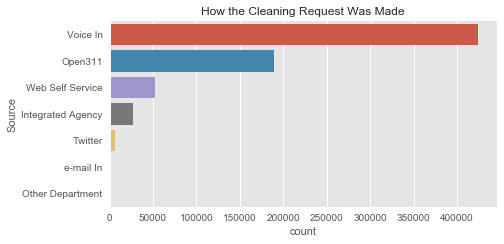

In [8]:
theOrder = ["Voice In", "Open311", "Web Self Service", "Integrated Agency", "Twitter", "e-mail In", "Other Department"]
#sns.set(font_scale = 1.5)
sns.set_context("notebook", rc={"font.size" : 40}) # font_scale=1.5
ax = sns.factorplot(y = "Source", data = street, kind = "count", orient = "h", order = theOrder, aspect = 2)#, size = 10)
plt.title("How the Cleaning Request Was Made") 
plt.show()

Most requests seem to be made by phone call.  
According to [the project's website](http://www.open311.org/learn/), Open311 allows people to report issues in public spaces to city officials through a [website](https://sf311.org/index.aspx?page=797) or [mobile app](https://www.sf311.org/mobile).  

Now we want to see which neighborhoods have the most requests. First we need to manipulate the data some.

In [9]:
# From: http://stackoverflow.com/questions/22391433/count-the-frequency-that-a-value-occurs-in-a-dataframe-column
counts = street.groupby('Neighborhood').count()

We can get the number of opened requests and the number of closed requests from this data frame and use them to calculate the proportion of requests that were opened, but not closed. 

In [10]:
counts = counts.sort_values(by = "CaseID",
                            ascending = False)
counts = counts.reset_index()
counts['UnclosedProp'] = (counts.Opened - counts.Closed) / counts.Opened
counts.head()

Neighborhood  CaseID  Opened  Closed  Status  Responsible Agency  \
0          Mission   96712   96712   95382   96712               96712   
1  South of Market   65269   65269   64275   65269               65269   
2     Civic Center   36750   36750   36542   36750               36750   
3       Tenderloin   28495   28495   28059   28495               28495   
4          Bayview   25956   25956   25658   25956               25956   

   Address  Category  Request Type  Request Details      ...       Females  \
0    96712     96712         96700            96698      ...         96712   
1    65269     65269         65263            65263      ...         65269   
2    36750     36750         36749            36748      ...         36750   
3    28495     28495         28494            28494      ...         28495   
4    25956     25956         25956            25955      ...         25956   

   HousePrice  Males  MedAgeF  MedAgeM  MedHouseholdIncome  MedRent  \
0       96712  96712    96712    96712               96712    96712   
1           0  65269    65269    65269               65269    65269   
2           0  36750    36750    36750               36750    36750   
3           0  28495    28495    28495               28495    28495   
4       25956  25956    25956    25956               25956    25956   

   PeoplePerSqMi  Population  UnclosedProp  
0          96712       96712      0.013752  
1          65269       65269      0.015229  
2          36750       36750      0.005660  
3          28495       28495      0.015301  
4          25956       25956      0.011481  

[5 rows x 26 columns]

Now we can make a bar plot, but since there are so many neighborhoods, we only looked at the top and bottom 15 to keep the plot readable. We are just looking at overall count of requests to start.

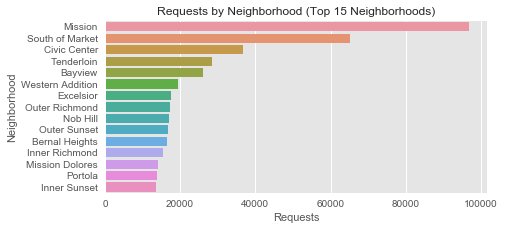

In [11]:
sns.set_context("notebook", rc={"font.size" : 40}) # font_scale=1.5
ax = sns.factorplot(x = "CaseID", 
                    y = "Neighborhood",
                    data = counts.head(15), 
                    kind = "bar", 
                    orient = "h", 
                    aspect = 2
                   )#, size = 10)
ax.set_xlabels("Requests")
plt.title("Requests by Neighborhood (Top 15 Neighborhoods)") 
plt.show()

So Mission and South of Market have had a lot more cleaning requests than the rest of the neighborhoods.

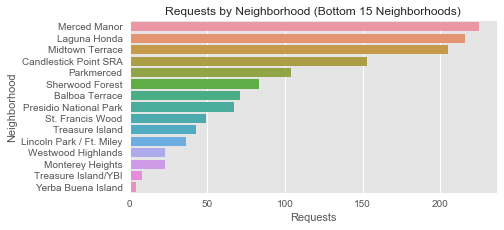

In [12]:
sns.set_context("notebook", rc={"font.size" : 40}) # font_scale=1.5
ax = sns.factorplot(x = "CaseID", 
                    y = "Neighborhood",
                    data = counts.tail(15), 
                    kind = "bar", 
                    orient = "h", 
                    aspect = 2
                   )#, size = 10)
ax.set_xlabels("Requests")
plt.title("Requests by Neighborhood (Bottom 15 Neighborhoods)") 
plt.show()

Treasure Island and Yerba Buena Island have the least requests. This is probably because they are small islands separated a bit from the rest of the city.

To get a sense of where these neighborhood fall on a map, we created this plot:

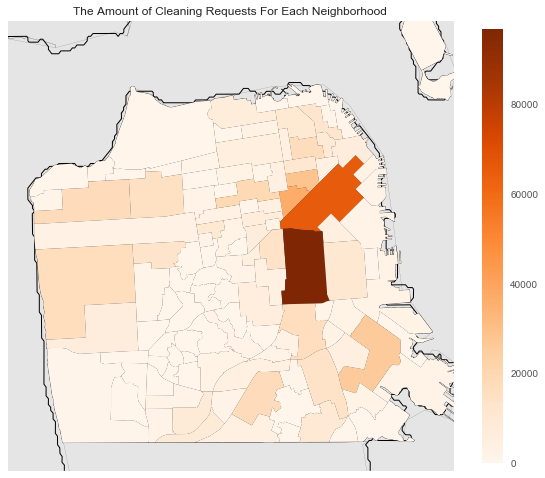

In [13]:
fig, ax = plt.subplots(figsize=(10,20))

# Using counts: "Neighborhood" and "Opened"

myMap = Basemap(llcrnrlon=-122.523, llcrnrlat=37.7, urcrnrlon=-122.36, urcrnrlat=37.83, resolution="f",
    projection="merc") 
myMap.drawcoastlines()
myMap.drawcounties()
myMap.readshapefile("ShapeFiles/geo_export_c540f0fb-6194-47ad-9fa9-12150ac3dd4c", 
                    "noises")

neighs  = gpd.read_file("ShapeFiles/geo_export_c540f0fb-6194-47ad-9fa9-12150ac3dd4c.shp")

neighs = pd.DataFrame({
        'shapes': [Polygon(np.array(shape), True) for shape in myMap.noises], 
        'Neighborhood': [n['name'] for n in myMap.noises_info] })

neighs = neighs.merge(counts, on = "Neighborhood", how = "left")

cmap = plt.get_cmap('Oranges')   
pc = PatchCollection(neighs.shapes, zorder = 2)
norm = Normalize()
pc.set_facecolor(cmap(norm(neighs['Opened'].fillna(0).values)))
ax.add_collection(pc) # was ax.

mapper = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
mapper.set_array(neighs['Opened'])
plt.colorbar(mapper, shrink=0.4)

plt.title("The Amount of Cleaning Requests For Each Neighborhood")

Mission and South of Market really stand out on this map, and they are next to each other which is interesting. They are also among the bigger neighborhoods, which might be a factor. Treasure Island and YBI can be seen in the top right corner of this map and their distance from the rest of San Francisco can really be seen. 

We also examined the proportion of unclosed requests in each neighborhood. 

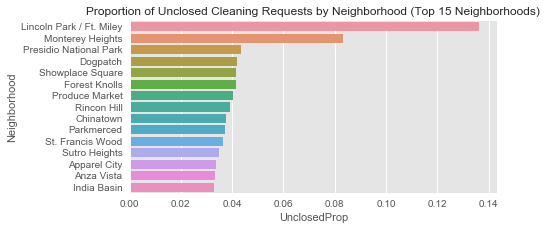

In [15]:
sns.set_context("notebook", rc={"font.size" : 40}) # font_scale=1.5
ax = sns.factorplot(x = "UnclosedProp", 
                    y = "Neighborhood",
                    data = counts.sort_values(by = "UnclosedProp",
                                              ascending = False).head(15), 
                    kind = "bar", 
                    orient = "h", 
                    aspect = 2
                   )
plt.title("Proportion of Unclosed Cleaning Requests by Neighborhood (Top 15 Neighborhoods)") 
plt.show()

As also seen on the following map and the plot above, Lincoln Park / Ft. Miley has the highest proportion of unclosed requests. 

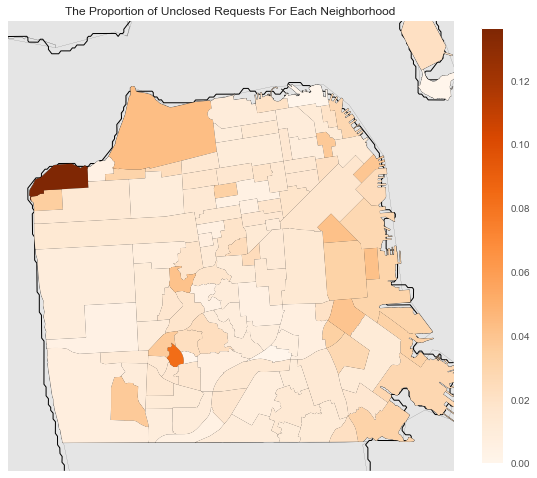

In [16]:
fig, ax = plt.subplots(figsize=(10,20))

# Using counts: "Neighborhood" and "Opened"

myMap = Basemap(llcrnrlon=-122.523, 
                llcrnrlat=37.7, 
                urcrnrlon=-122.36, 
                urcrnrlat=37.83, 
                resolution="f",
                projection="merc") 

myMap.drawcoastlines()
myMap.drawcounties()
myMap.readshapefile("ShapeFiles/geo_export_c540f0fb-6194-47ad-9fa9-12150ac3dd4c", "noises")

neighs  = gpd.read_file("ShapeFiles/geo_export_c540f0fb-6194-47ad-9fa9-12150ac3dd4c.shp")

neighs = pd.DataFrame({
        'shapes': [Polygon(np.array(shape), True) for shape in myMap.noises], 
        'Neighborhood': [n['name'] for n in myMap.noises_info] })

neighs = neighs.merge(counts, on = "Neighborhood", how = "left")

cmap = plt.get_cmap('Oranges')   
pc = PatchCollection(neighs.shapes, zorder = 2)
norm = Normalize()
pc.set_facecolor(cmap(norm(neighs['UnclosedProp'].fillna(0).values)))
ax.add_collection(pc) # was ax.

mapper = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
mapper.set_array(neighs['UnclosedProp'])
plt.colorbar(mapper, shrink=0.4)

plt.title("The Proportion of Unclosed Requests For Each Neighborhood")

We then calculated the number of requests by type.  

In [17]:
request_counts = street.groupby(by = "Request Type").count().reset_index().ix[:,["Request Type","CaseID"]].sort_values(by = "CaseID", ascending = False)

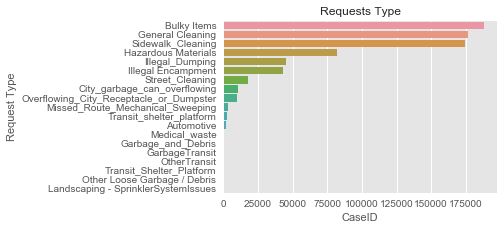

In [18]:
sns.set_context("notebook", rc={"font.size" : 40}) # font_scale=1.5
ax = sns.factorplot(y = "Request Type", 
                    x = "CaseID",
                    data = request_counts, 
                    kind = "bar", 
                    orient = "h", 
                    aspect = 2
                   )#, size = 10)
plt.title("Requests Type") 
plt.show()

So bulky items, general cleaning, and sidewalk cleaning are the most common. 

We added the month of each request to compare the counts of requests by month.  

In [23]:
street['month'] = [timestamp.month for timestamp in street.Opened]

In [20]:
count_by_month = street.groupby(by='month').count().CaseID.reset_index()

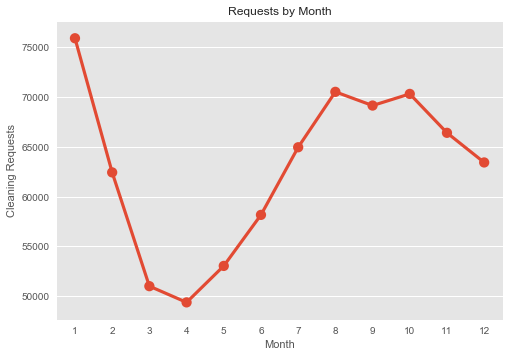

In [21]:
sns.set_context("notebook", rc={"font.size" : 40}) # font_scale=1.5
ax = sns.pointplot(y = "CaseID", 
                    x = "month",
                    data = count_by_month, 
                    kind = "bar", 
                    aspect = 3,
                   )#, size = 10)
ax.set_ylabel("Cleaning Requests")
ax.set_xlabel("Month")
plt.title("Requests by Month") 
plt.show()

The number of requests seems to be highest in the summer, and lowest in late winter and spring.  

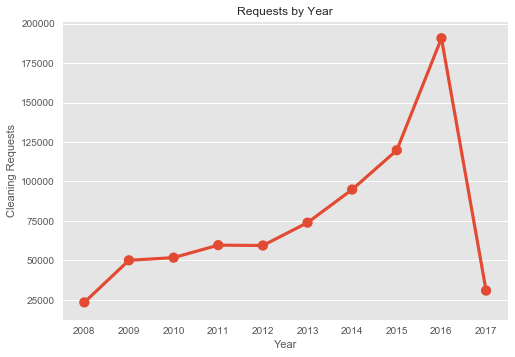

In [22]:
street['year'] = [timestamp.year for timestamp in street.Opened]
count_by_year = street.groupby(by='year').count().CaseID.reset_index()
sns.set_context("notebook", rc={"font.size" : 40}) # font_scale=1.5
ax = sns.pointplot(y = "CaseID", 
                    x = "year",
                    data = count_by_year, 
                    kind = "bar", 
                    aspect = 3,
                   )#, size = 10)
ax.set_ylabel("Cleaning Requests")
ax.set_xlabel("Year")
plt.title("Requests by Year") 
plt.show()

So the number of requests have been increasing each year, 

### Demographic Plots

We calculated the number of hours required to close each request.

In [72]:
def get_Timedelta_hours(endtime, starttime):
    # import pandas as pd
    #assert(isinstance(endtime, pd.tslib.Timestamp) and isinstance(starttime, pd.tslib.Timestamp))
    
    try:
        td = endtime - starttime

        # Return hours
        return td.seconds / 3600.0
    except:
        return None

get_Timedelta_hours(street.ix[0,"Closed"], street.ix[0,"Opened"])

2.6041666666666665

In [73]:
street["HoursToClose"] = [get_Timedelta_hours(closed, opened) for closed, opened in zip(street.Closed, street.Opened)]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8addb942d0>]], dtype=object)

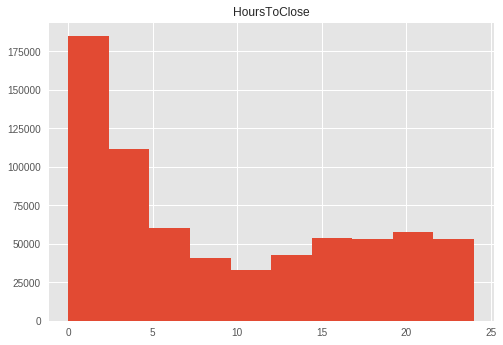

In [84]:
street.hist("HoursToClose")

From the histogram, it seems that requests take at most about a day to close. 

To check for potential associations between the time to close a request and the other numeric variables, we used a correlation matrix.  

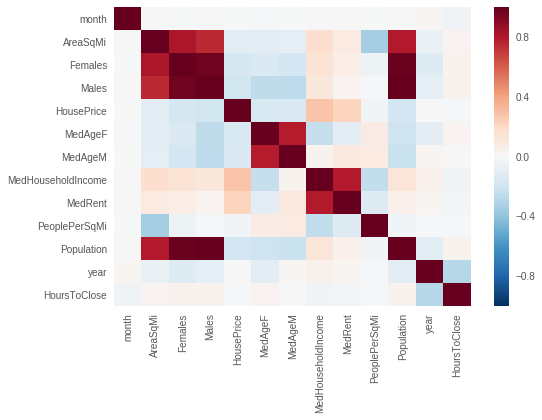

In [82]:
# Source: https://stackoverflow.com/questions/29432629/correlation-matrix-using-pandas
corr = street[["month", 
               "AreaSqMi", 
               "Females", 
               "Males", 
               "HousePrice",
               "MedAgeF",
               "MedAgeM",
               "MedHouseholdIncome",
               "MedRent",
               "PeoplePerSqMi",
               "Population",
               "year",
               "HoursToClose"]].corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

There seems to be a small negative correlation between the hours required to close a request and the year, which indicates that requests are being closed faster now than they were initially. The correlations between the hours required to close a request and the other variables seem to be very weak.

We calculated the mean hours to close requests for each neighborhood.

In [92]:
hrs_by_neigh = street.groupby("Neighborhood").mean()[["HoursToClose"]].reset_index()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8adda1ead0>]], dtype=object)

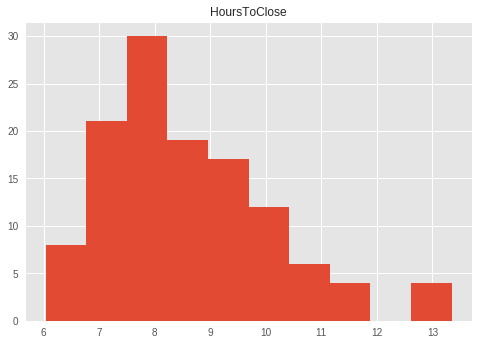

In [97]:
hrs_by_neigh.hist("HoursToClose")

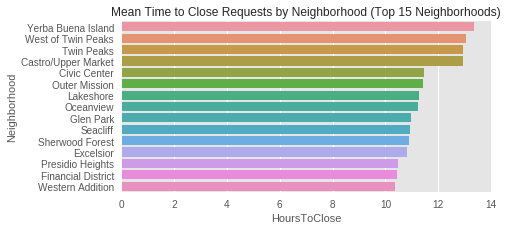

In [106]:
sns.set_context("notebook", rc={"font.size" : 40}) # font_scale=1.5
ax = sns.factorplot(x = "HoursToClose", 
                    y = "Neighborhood",
                    data = hrs_by_neigh.sort_values(by = "HoursToClose",
                                                    ascending = False).head(15), 
                    kind = "bar", 
                    orient = "h", 
                    aspect = 2
                   )
plt.title("Mean Time to Close Requests by Neighborhood (Top 15 Neighborhoods)") 
plt.show()

This plot indicates that Yerba Buena Island, West of Twin Peaks, Twin Peaks, and Castro/Upper Market have cleaning requests that take longer to fill than any other neighborhoods. 

Yerba Buena Island is an island, which might make it more difficult to get cleaning staff and equipment to. The Twin Peaks neighborhood contains the titular hills, which might cause some requests to be more remote and difficult to access. It isn't immediately apparent why cleaning requests in Castro/Upper Market might take longer than in most neighborhoods. According to the [Wikipedia page](https://en.wikipedia.org/wiki/Castro_District,_San_Francisco) for Castro, the neighborhood has historically included a large Scandinavian and LGBT population.   

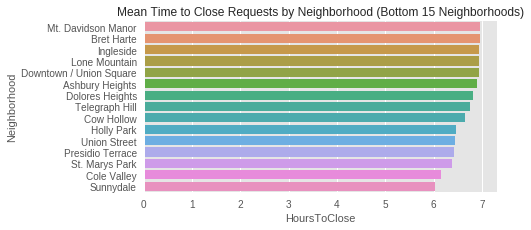

In [104]:
sns.set_context("notebook", rc={"font.size" : 40}) # font_scale=1.5
ax = sns.factorplot(x = "HoursToClose", 
                    y = "Neighborhood",
                    data = hrs_by_neigh.sort_values(by = "HoursToClose",
                                                    ascending = False).tail(15), 
                    kind = "bar", 
                    orient = "h", 
                    aspect = 2
                   )
plt.title("Mean Time to Close Requests by Neighborhood (Bottom 15 Neighborhoods)") 
plt.show()

In comparison, there don't seem to be any neighborhoods that have substantially lower mean time to close requests than almost all other neighborhoods.  

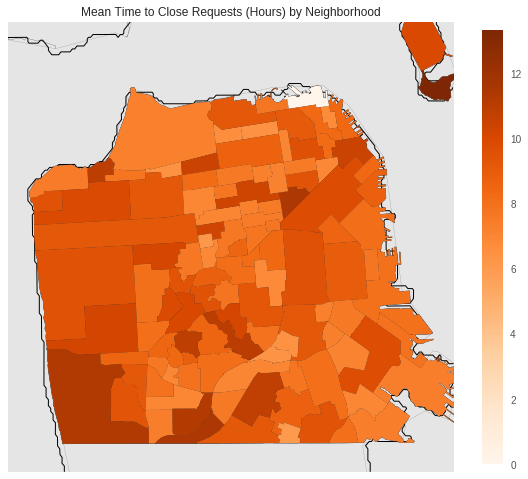

In [95]:
fig, ax = plt.subplots(figsize=(10,20))

myMap = Basemap(llcrnrlon=-122.523, 
                llcrnrlat=37.7, 
                urcrnrlon=-122.36, 
                urcrnrlat=37.83, 
                resolution="f",
                projection="merc") 

myMap.drawcoastlines()
myMap.drawcounties()
myMap.readshapefile("ShapeFiles/geo_export_c540f0fb-6194-47ad-9fa9-12150ac3dd4c", "noises")

neighs  = gpd.read_file("ShapeFiles/geo_export_c540f0fb-6194-47ad-9fa9-12150ac3dd4c.shp")

neighs = pd.DataFrame({
        'shapes': [Polygon(np.array(shape), True) for shape in myMap.noises], 
        'Neighborhood': [n['name'] for n in myMap.noises_info] })

neighs = neighs.merge(hrs_by_neigh, on = "Neighborhood", how = "left")

cmap = plt.get_cmap('Oranges')   
pc = PatchCollection(neighs.shapes, zorder = 2)
norm = Normalize()
pc.set_facecolor(cmap(norm(neighs['HoursToClose'].fillna(0).values)))
ax.add_collection(pc) # was ax.

mapper = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
mapper.set_array(neighs['HoursToClose'])
plt.colorbar(mapper, shrink=0.4)

plt.title("Mean Time to Close Requests (Hours) by Neighborhood")

This map also shows the time to close requests by neighborhood; Yerba Buena island, which has the longest time, is visible in the upper right.  

--------

# Events and Festivals Plots

## Pride

We merged data about attendance scraped from the [San Francisco Pride Wikipedia Page](https://en.wikipedia.org/wiki/San_Francisco_Pride) with the requests data to find the number of requests that were submitted on the days of the parade and in the neighborhoods surrounding the parade, shown in the following table.    

In [25]:
# Read the data scraped in the other notebook
pride = pd.DataFrame.from_csv("pride.csv")
pride

DateOpened  ReqCount_y  attendance_num_x  Year StartNoTime   EndNoTime
0  2009-06-27          39         1200000.0  2009  2009-06-27  2009-06-28
1  2010-06-26          61         1200000.0  2010  2010-06-26  2010-06-27
2  2011-06-25          63         1000000.0  2011  2011-06-25  2011-06-26
3  2012-06-23          56               NaN  2012  2012-06-23  2012-06-24
4  2013-06-29          37         1500000.0  2013  2013-06-29  2013-06-30
5  2014-06-28          62         1700000.0  2014  2014-06-28  2014-06-29
6  2015-06-27          68         1800000.0  2015  2015-06-27  2015-06-28
7  2016-06-25         108               NaN  2016  2016-06-25  2016-06-26

We used a scatterplot to see if there might be an association between the event attendance and the number of requests.

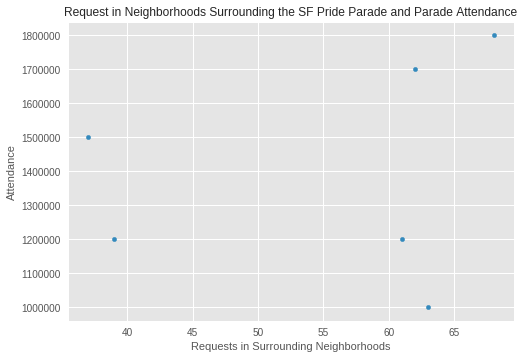

In [26]:
pride.plot(x="ReqCount_y", y="attendance_num_x", kind="scatter")
plt.title("Request in Neighborhoods Surrounding the SF Pride Parade and Parade Attendance")
plt.ylabel("Attendance")
plt.xlabel("Requests in Surrounding Neighborhoods")

There does not seem to be an association between the pride parade and requests in the surrounding neighborhoods.  
We used the correlation between these variables, shown below, for confirmation:  

In [27]:
pride[["ReqCount_y", "attendance_num_x"]].corr()

ReqCount_y  attendance_num_x
ReqCount_y           1.00000           0.20293
attendance_num_x     0.20293           1.00000

## Outside Lands

We used the dates of the Outside Lands Festival obtained by scraping the Wikipedia page to assess any association between cleaning requests and the festival.

In [28]:
# Read the dates of the festival obtained from scraping
ol_dates_df = pd.DataFrame.from_csv("ol_dates.csv", parse_dates=["Festival_Date"])
#ol_dates_df

ol_dates = pd.DatetimeIndex(ol_dates_df.Festival_Date)
ol_dates

DatetimeIndex(['2008-08-22', '2008-08-23', '2008-08-24', '2009-08-28',
               '2009-08-29', '2010-08-14', '2010-08-15', '2011-08-12',
               '2011-08-14', '2012-08-10', '2012-08-12', '2013-08-09',
               '2013-08-11', '2014-08-08', '2014-08-10', '2015-08-07',
               '2015-08-09', '2016-08-05', '2016-08-09'],
              dtype='datetime64[ns]', name=u'Festival_Date', freq=None)

In [29]:
# Find all requests in August in Golden Gate Park
AugustRequests = street.loc[street["Opened"].dt.month == 8]
AugustRequests["DateOpened"] = AugustRequests["Opened"].dt.date 
OLNeighs = ["Golden Gate Park"]
AugustRequests = AugustRequests.loc[AugustRequests.Neighborhood.isin(OLNeighs)]

/home/tgordon/.local/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [30]:
type(AugustRequests["DateOpened"].values[0])
type(ol_dates[0])

# Convert the dates
ol_dt = [d.date() for d in ol_dates]

# Select all cleaning requests on the days of the festival
ol_req = AugustRequests[AugustRequests.DateOpened.isin(ol_dt)]

# Count the cleaning requests on each day of the festival
ol_req_counts = ol_req[["CaseID", "DateOpened"]].groupby("DateOpened").count()
ol_req_counts

CaseID
DateOpened        
2009-08-29       2
2010-08-15       1
2011-08-12       1
2011-08-14       1
2013-08-09       4
2014-08-08       2
2014-08-10       1
2015-08-07       1
2016-08-05       1

To determine if the number of cleaning requests on the days that Outside Lands took place was unusual, we compared it with the usual number of requests on days in August.  

In [31]:
# Add a new day column to allow groupby
AugustRequests["Day"] = AugustRequests["Opened"].dt.day

# Count the number of requests per day across all years
Aug_req_by_day = AugustRequests[["CaseID", "Day"]].groupby('Day').count()

# There are 8 years in the data set, so divide the counts by 8 to get the average for each day
Aug_req_by_day.CaseID = Aug_req_by_day.CaseID / 8

Aug_req_by_day.head()

CaseID
Day        
1     2.000
2     2.000
3     1.250
4     0.375
5     1.250

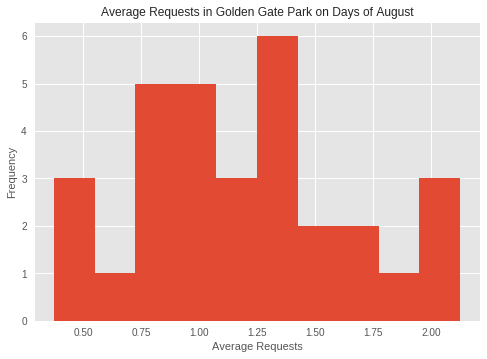

In [32]:
Aug_req_by_day.hist()
plt.title("Average Requests in Golden Gate Park on Days of August")
plt.xlabel("Average Requests")
plt.ylabel("Frequency")

In [33]:
np.mean(Aug_req_by_day.CaseID)

1.1814516129032258

In [34]:
np.median(Aug_req_by_day.CaseID)

1.125

From the mean and median, a "normal" number of requests in Golden Gate Park on a day in August is about 1.3. All but one of the number of requests on the days of the festival is 1 or 2, so it seems fairly clear that there is no consistent association between the festival and cleaning request in the park. 

Neither event we examined seems to be associated with increased cleaning requests. This may be because the city allocates additional cleaning resources in anticipation of large events, or the events may hire their own staff for cleaning.  

--------